# Results OOD EvalBALD Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files("./results/ood_eval_bald")

In [ ]:
get_any(results)

_Result(timestamp=1620924251, cmdline=['/auto/users/andsch/github/active_learning_redux/batchbald_redux/uniform_target_ood_experiment.py', '--id=16'], commit='7a88a46c213fc419b8e48358058ec72fe5b0f546', github_url='7a88a46c213fc419b8e48358058ec72fe5b0f546', experiment='/auto/users/andsch/github/active_learning_redux/batchbald_redux/uniform_target_ood_experiment.py', job_id=16, worker_id=16, num_workers=20, config=_config(seed=1258, acquisition_size=10, max_training_set=450, num_pool_samples=100, num_validation_samples=20, num_training_samples=1, num_patience_epochs=3, max_training_epochs=30, training_batch_size=64, device='cuda', validation_set_size=1024, evaluation_set_size=100, validation_split_random_state=0, initial_training_set_size=20, min_samples_per_epoch=5056, mnist_repetitions=1, ood_fmnist_repetitions=1, add_dataset_noise=False, acquisition_function='batchbald_redux.acquisition_functions.TemperedEvalBALD', train_eval_model='batchbald_redux.train_eval_model.TrainSelfDistillati

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,16,1620924251
1,4,1620920896
2,1,1620908107
3,4,1620908041
4,10,1620922870
5,13,1620946067
6,19,1620918611
7,8,1620922124
8,3,1620920866
9,15,1620924161


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

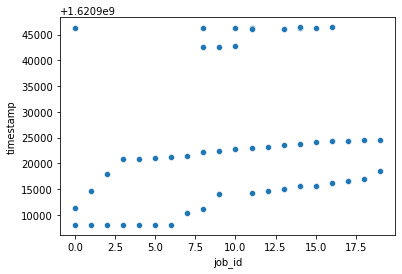

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
#grd.axhline(y=790000 + 1.609e9)
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(20, 52)

In [ ]:
results.keys()

dict_keys(['/uniform_target_ood_experiment_job_16_2021-05-13-174411.py', '/uniform_target_ood_experiment_job_4_2021-05-13-164816.py', '/rejection_ood_experiment_job_1_2021-05-13-131507.py', '/rejection_ood_experiment_job_4_2021-05-13-131400.py', '/uniform_target_ood_experiment_job_10_2021-05-13-172110.py', '/uniform_target_ood_experiment_job_13_2021-05-13-234747.py', '/rejection_ood_experiment_job_19_2021-05-13-161011.py', '/uniform_target_ood_experiment_job_8_2021-05-13-170844.py', '/uniform_target_ood_experiment_job_3_2021-05-13-164746.py', '/uniform_target_ood_experiment_job_15_2021-05-13-174241.py', '/rejection_ood_experiment_job_3_2021-05-13-131400.py', '/uniform_target_ood_experiment_job_11_2021-05-13-172210.py', '/rejection_ood_experiment_job_11_2021-05-13-235237.py', '/rejection_ood_experiment_job_8_2021-05-13-235200.py', '/uniform_target_ood_experiment_job_0_2021-05-13-140858.py', '/rejection_ood_experiment_job_0_2021-05-13-235142.py', '/rejection_ood_experiment_job_16_2021-05

### Rejection OOD
```
configs = [
    RejectionOodExperiment(
        seed=seed,
        acquisition_function=acquisition_functions.BALD,
        acquisition_size=acquisition_size,
        num_pool_samples=num_pool_samples,
    )
    for seed in range(5)
    for acquisition_size in [5, 10, 20, 50]
    for num_pool_samples in [100]
] + [
    RejectionOodExperiment(
        seed=seed,
        acquisition_function=acquisition_functions.Random,
        acquisition_size=5,
    )
    for seed in range(20)
]
```

### Uniform Target OOD

```
configs = [
    UniformTargetOodExperiment(
        seed=seed,
        acquisition_function=acquisition_functions.TemperedBALD,
        acquisition_size=acquisition_size,
        num_pool_samples=num_pool_samples,
        temperature=8,
    )
    for seed in range(5)
    for acquisition_size in [5, 10, 20, 50]
    for num_pool_samples in [100]
] + [
    UniformTargetOodExperiment(
        seed=seed,
        acquisition_function=acquisition_functions.Random,
        acquisition_size=5,
    )
    for seed in range(20)
]
```

In [ ]:
experiment_data = []

for file, result in results.items():
    try:
        if not hasattr(result, "config"):
            print(file, "empty")
            continue
        if hasattr(result, "exception"):
            print(file, "exception")
            continue

        if "rejection_ood" in file:
            ood_type = "rejection_ood"
        elif "uniform_target_ood" in file:
            ood_type = "uniform_target_ood"
        else:
            raise Exception(f"Unknown ood_type for {file}!")

        acquisition_size = result.config.acquisition_size
        acquisition_function = result.config.acquisition_function[len("batchbald_redux.acquisition_functions.") :]
        num_pool_samples = result.config.num_pool_samples
        evaluation_set_size = len(result.evaluation_set_indices)
        initial_set_size = len(result.initial_training_set_indices)
        
        seed = result.config.seed

        if acquisition_function == "Random":
            acquisition_sizes = [5, 10, 20, 50]
        else:
            acquisition_sizes = [acquisition_size]

        # if acquisition_function == "Random":
        #     num_pool_samples = [10, 20, 50, 100]
        # else:
        num_pool_samples = [num_pool_samples]

        for nps in num_pool_samples:
            for acquisition_size in acquisition_sizes:
                if (
                    initial_set_size
                    + sum(1 if hasattr(step, "evaluation_metrics") else 0 for step in result.active_learning_steps)
                    * result.config.acquisition_size
                    < 250
                ):
                    print(len(result.active_learning_steps), file)
                    continue

                num_acquired_ood_samples = 0
                for i, step in enumerate(result.active_learning_steps):
                    if not hasattr(step, "evaluation_metrics"):
                        print(step)
                        break
                    if i != len(result.active_learning_steps) - 1 and not hasattr(step, "acquisition"):
                        print(file, i)
                        break

                    total_acquisitions = i * result.config.acquisition_size
                    training_set_size = initial_set_size + total_acquisitions
                    accuracy = step.evaluation_metrics.accuracy

                    if hasattr(step, "acquisition"):
                        if ood_type == "uniform_target_ood":
                            num_acquired_ood_samples += sum(index[0] == "ood" for index in step.acquisition.indices)
                        elif ood_type == "rejection_ood":
                            num_acquired_ood_samples += sum(label == -1 for label in step.acquisition.labels)

                    experiment_data.append(
                        dict(
                            ood_type=ood_type,
                            acquisition_function=acquisition_function,
                            acquisition_size=acquisition_size,
                            num_pool_samples=nps,
                            training_set_size=training_set_size,
                            accuracy=accuracy,
                            evaluation_set_size=evaluation_set_size,
                            seed=seed,
                            num_acquired_ood_samples=num_acquired_ood_samples,
                            total_acquisitions=total_acquisitions,
                            acquired_ood_sample_ratio=num_acquired_ood_samples/total_acquisitions if total_acquisitions > 0 else 0
                        )
                    )
    except:
        print(file)
        raise

4 /uniform_target_ood_experiment_job_8_2021-05-13-170844.py
18 /uniform_target_ood_experiment_job_15_2021-05-13-174241.py
8 /uniform_target_ood_experiment_job_11_2021-05-13-172210.py
/rejection_ood_experiment_job_11_2021-05-13-235237.py exception
/rejection_ood_experiment_job_8_2021-05-13-235200.py exception
/rejection_ood_experiment_job_0_2021-05-13-235142.py exception
/rejection_ood_experiment_job_16_2021-05-13-235314.py exception
/uniform_target_ood_experiment_job_14_2021-05-13-235105.py exception
/rejection_ood_experiment_job_14_2021-05-13-235256.py exception
7 /rejection_ood_experiment_job_14_2021-05-13-152015.py
1 /uniform_target_ood_experiment_job_13_2021-05-13-173241.py
5 /uniform_target_ood_experiment_job_9_2021-05-13-171410.py
6 /uniform_target_ood_experiment_job_14_2021-05-13-173440.py
/rejection_ood_experiment_job_10_2021-05-13-235219.py exception
/uniform_target_ood_experiment_job_15_2021-05-13-235124.py exception
17 /rejection_ood_experiment_job_11_2021-05-13-145740.py


In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,ood_type,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,evaluation_set_size,seed,num_acquired_ood_samples,total_acquisitions,acquired_ood_sample_ratio
0,uniform_target_ood,TemperedEvalBALD,10,100,20,0.6816,100,1258,0,0,0.000000
1,uniform_target_ood,TemperedEvalBALD,10,100,30,0.7346,100,1258,0,10,0.000000
2,uniform_target_ood,TemperedEvalBALD,10,100,40,0.7576,100,1258,0,20,0.000000
3,uniform_target_ood,TemperedEvalBALD,10,100,50,0.7446,100,1258,0,30,0.000000
4,uniform_target_ood,TemperedEvalBALD,10,100,60,0.8000,100,1258,1,40,0.025000
...,...,...,...,...,...,...,...,...,...,...,...
2290,rejection_ood,TemperedEvalBALD,10,100,1010,0.9740,1000,1253,576,990,0.581818
2291,rejection_ood,TemperedEvalBALD,10,100,1020,0.9713,1000,1253,583,1000,0.583000
2292,rejection_ood,TemperedEvalBALD,10,100,1030,0.9755,1000,1253,593,1010,0.587129
2293,rejection_ood,TemperedEvalBALD,10,100,1040,0.9754,1000,1253,598,1020,0.586275


In [ ]:
df.acquisition_size.unique()

array([10])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("training_set_size == 20").groupby(["ood_type", "acquisition_size", "evaluation_set_size"])["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

ood_type            acquisition_size  evaluation_set_size  acquisition_function
rejection_ood       10                100                  TemperedEvalBALD         8
                                      1000                 TemperedEvalBALD         9
uniform_target_ood  10                100                  TemperedEvalBALD        10
                                      1000                 TemperedEvalBALD         9
Name: num_trials, dtype: int64


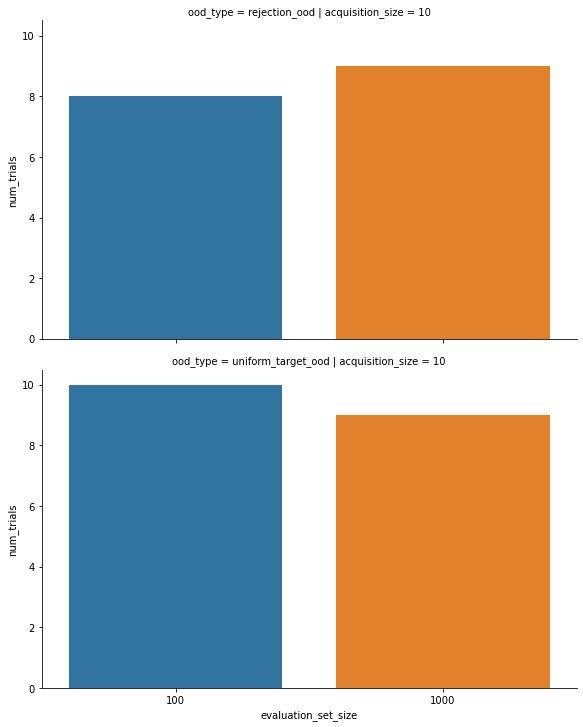

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="evaluation_set_size",
    col="acquisition_size",
    row="ood_type",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

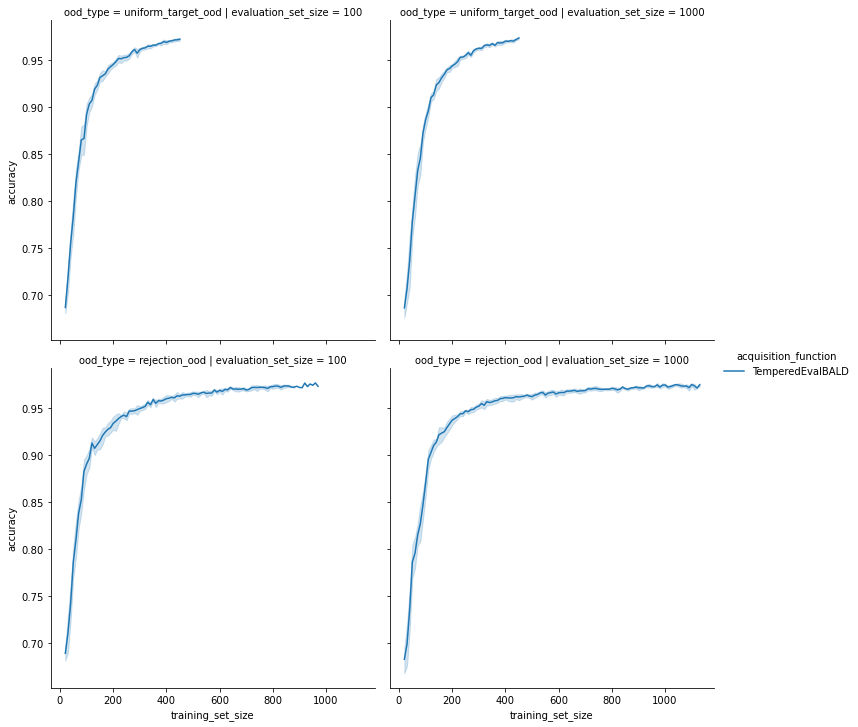

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="evaluation_set_size",
    row="ood_type",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

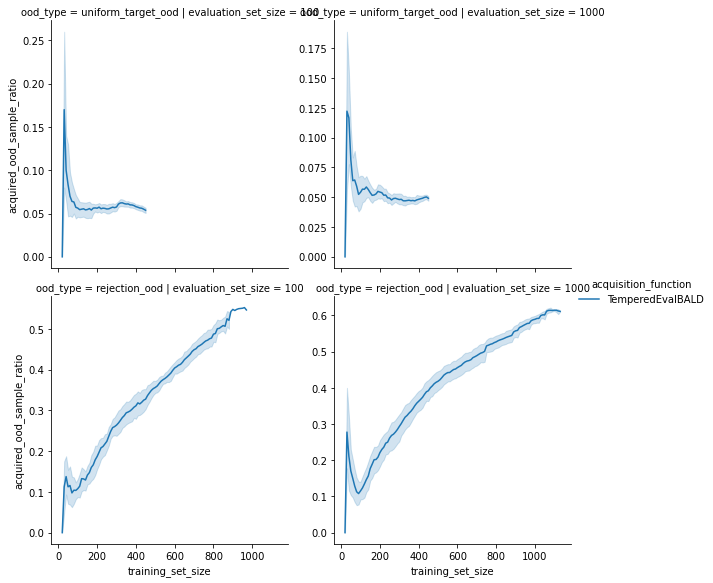

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="acquired_ood_sample_ratio",
    col="evaluation_set_size",
    row="ood_type",
    hue="acquisition_function",
    data=df[df["acquisition_function"]!="Random"],
    kind="line",
    height=4,
    facet_kws=dict(sharey=False)
)

grd.fig.patch.set_alpha(1)

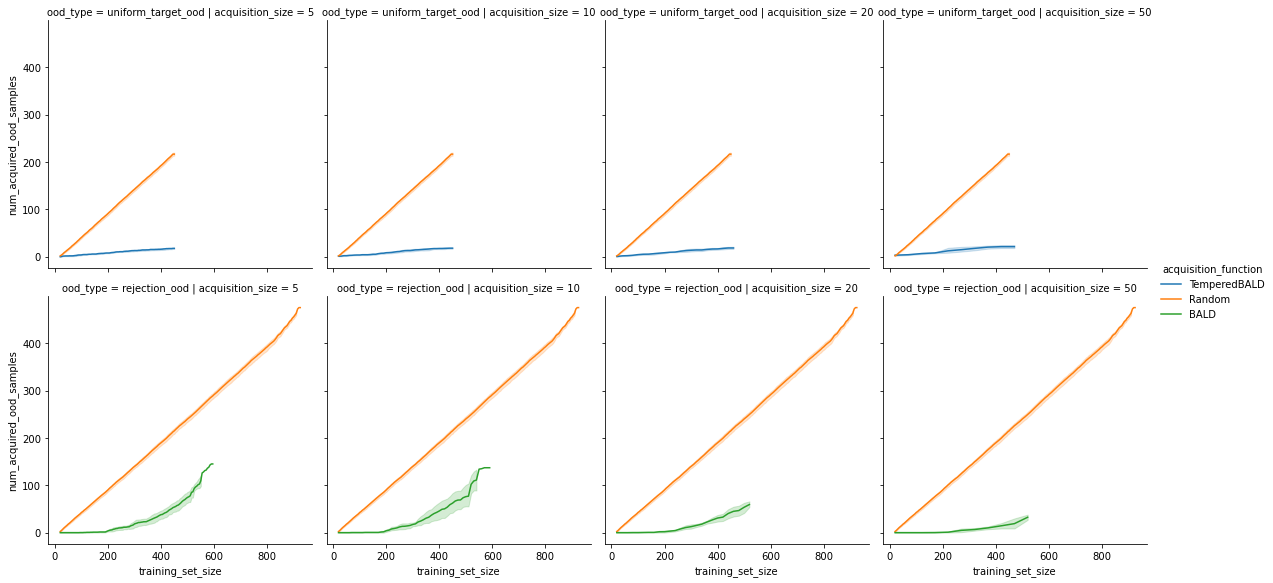

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="num_acquired_ood_samples",
    col="acquisition_size",
    row="ood_type",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=4,
)

grd.fig.patch.set_alpha(1)

In [ ]:
import qgrid

df["max_accuracy"] = df.groupby(["seed", "acquisition_size", "acquisition_function", "num_pool_samples"]).accuracy.cummax()

df_max_accuracy = df.drop_duplicates(subset=["seed", "acquisition_size", "acquisition_function", "num_pool_samples", "max_accuracy"])
#qgrid.show_grid(df_max_accuracy)
df_max_accuracy

,ood_type,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed,num_acquired_ood_samples,total_acquisitions,acquired_ood_sample_ratio,max_accuracy
0,uniform_target_ood,TemperedBALD,50,50,20,0.6165,23,4,0,0.000000,0.6165
1,uniform_target_ood,TemperedBALD,50,50,70,0.8098,23,4,50,0.080000,0.8098
2,uniform_target_ood,TemperedBALD,50,50,120,0.8523,23,8,100,0.080000,0.8523
3,uniform_target_ood,TemperedBALD,50,50,170,0.8704,23,9,150,0.060000,0.8704
4,uniform_target_ood,TemperedBALD,50,50,220,0.8912,23,11,200,0.055000,0.8912
...,...,...,...,...,...,...,...,...,...,...,...
22498,rejection_ood,Random,50,20,710,0.9345,24,361,690,0.523188,0.9345
22507,rejection_ood,Random,50,20,755,0.9367,24,385,735,0.523810,0.9367
22516,rejection_ood,Random,50,20,800,0.9371,24,402,780,0.515385,0.9371
22520,rejection_ood,Random,50,20,820,0.9391,24,407,800,0.508750,0.9391


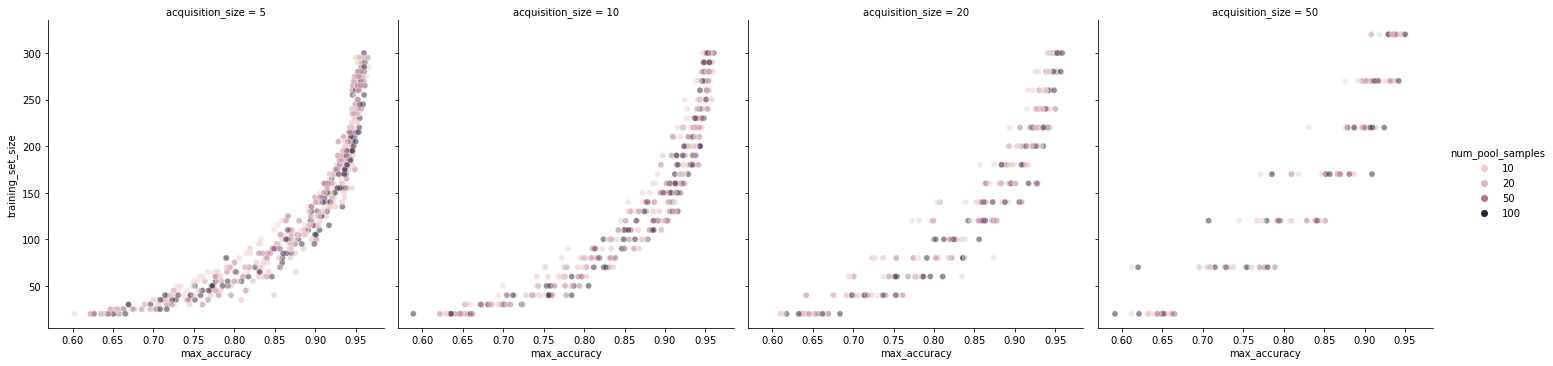

In [ ]:
grd = sns.relplot(
    y="training_set_size",
    x="max_accuracy",
    col="acquisition_size",
    hue="num_pool_samples",
    data=df_max_accuracy[df_max_accuracy.acquisition_function != "random"],
    kind="scatter",
    height=5,
    alpha=0.5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[(df.accuracy >= 0.90) & (df.acquisition_function != "random")].groupby(["seed", "acquisition_size", "acquisition_function", "num_pool_samples"]).first()

In [ ]:
df3 = df2.groupby(["acquisition_size", "acquisition_function", "num_pool_samples"]).training_set_size.quantile([0.25, 0.5, 0.75])

In [ ]:
print(df3.unstack())

                                                         0.25   0.50   0.75
acquisition_size acquisition_function num_pool_samples                     
5                bald                 10                125.0  135.0  140.0
                                      20                115.0  120.0  125.0
                                      50                130.0  140.0  140.0
                                      100               125.0  125.0  130.0
10               bald                 10                140.0  160.0  210.0
                                      20                130.0  140.0  140.0
                                      50                130.0  160.0  160.0
                                      100               130.0  140.0  150.0
20               bald                 10                180.0  200.0  200.0
                                      20                180.0  200.0  200.0
                                      50                160.0  180.0  200.0
            